## Imports and Helper Functions

In [1]:
import sys
#Path to Trane for imports
sys.path.append('/Users/Alexander/Documents/Trane/Trane__HDI_REPO')
path_to_datasets = '../Trane__Local_Misc/Formatted Datasets/Yelp Reviews v2/'
import pandas as pd
import trane
import json
import random
import datetime
import pickle
import featuretools as ft
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, datasets
from sklearn.metrics import accuracy_score
from sklearn import metrics
import scikitplot as skplt

def save_obj(obj, name):
    with open('pickled_objects/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open('pickled_objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def generate_probs_and_nl(entity_id_column,
                            label_generating_column,
                            time_column,
                            table_meta,
                            filter_column,
                            is_pick_random_problems = True):
    generator = trane.PredictionProblemGenerator(table_meta, entity_id_column, label_generating_column, time_column, filter_column)
    probs = []

    all_probs = list(generator.generate())

    if is_pick_random_problems:
        random.shuffle(all_probs)

    for idx, prob in enumerate(all_probs):
        probs.append(prob)
        if idx + 1 == NUM_PROBLEMS_TO_GENERATE:
            break
    prediction_problems_json = trane.prediction_problems_to_json_file(
        probs, table_meta, entity_id_column, label_generating_column, time_column, "prediction_problems.json")

    nl_descrips = trane.generate_nl_description(
        probs, table_meta, entity_id_column, label_generating_column, time_column, trane.ConstantIntegerCutoffTimes(0))
    return probs, nl_descrips
def convert(str, format = None):
    return datetime.datetime.strptime(str, format)
def file_to_table_meta(filepath):
    return trane.TableMeta(json.loads(open(filepath).read()))

## Load, Format and Sample Data

In [2]:
yelp_review_df = pd.read_csv(path_to_datasets + 'yelp_review.csv')
yelp_checkin_df = pd.read_csv(path_to_datasets + 'yelp_checkin.csv')
yelp_business_df = pd.read_csv(path_to_datasets + 'yelp_business.csv')
yelp_user_df = pd.read_csv(path_to_datasets + 'yelp_user.csv')

sampled_yelp_review_df = yelp_review_df.head(1000)
sampled_business_ids = sampled_yelp_review_df['business_id'].unique()
sampled_user_ids = sampled_yelp_review_df['user_id'].unique()
sampled_review_ids = sampled_yelp_review_df['review_id'].unique()
sampled_yelp_checkin_df = yelp_checkin_df[yelp_checkin_df['business_id'].isin(sampled_business_ids)]
sampled_yelp_business_df = yelp_business_df[yelp_business_df['business_id'].isin(sampled_business_ids)] 
sampled_yelp_user_df = yelp_user_df[yelp_user_df['user_id'].isin(sampled_user_ids)]

assert(len(sampled_business_ids) == len(sampled_yelp_business_df))
assert(len(sampled_user_ids) == len(sampled_yelp_user_df))
assert(len(sampled_review_ids) == len(sampled_yelp_review_df))

print("Sampling Reuslts ---")
print("Number of reviews: {}".format(len(sampled_yelp_review_df)))
print("Number of businesses: {}".format(len(sampled_business_ids)))
print("Number of users: {}".format(len(sampled_user_ids)))
print("Number of checkins: {}".format(len(sampled_yelp_checkin_df)))

merge_step_1 = pd.merge(sampled_yelp_review_df, sampled_yelp_user_df, how = 'left', on ='user_id')
merge_step_2 = pd.merge(merge_step_1, sampled_yelp_business_df, how = 'left', on = 'business_id')
merge_step_3 = pd.merge(merge_step_2, sampled_yelp_checkin_df, how = 'right', on = 'business_id')
merged_df = merge_step_3
merged_df['date'] = merged_df['date'].apply(str)
merged_df['date'] = merged_df['date'].apply(convert, format = '%Y-%m-%d')
merged_df = merged_df.rename(columns = {'stars_x': 'stars'})

distinct_business_ids_in_merged_df = merged_df['business_id'].unique()
#Note merged_df only contains 959 distinct business_ids. Checkins only contains information from 959 businesses.
#    That's why merged_df only has 959 distinct business_ids, as opposed to the 974 unique business_ids 
#    contained in the sample_yelp_review_df.
#Note merged_df contains more than the 78792 unique check-ins because there are multiple reviews for some business_ids so
#    each unique review_id is matched to a new business_id. There are 1000 review_ids, but only 974 business_ids.
#    

Sampling Reuslts ---
Number of reviews: 1000
Number of businesses: 974
Number of users: 45
Number of checkins: 78792


In [6]:
merged_df

,review_id,user_id,business_id,stars,date,text,useful_x,funny_x,cool_x,name_x,...,latitude,longitude,stars_y,review_count_y,is_open,categories,weekday,hour,checkins,checkin_id
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,Tim,...,45.523333,-73.594859,4.0,84,1,Diners;Food;Restaurants;Delis,Wed,17:00,5,51427
1,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,Tim,...,45.523333,-73.594859,4.0,84,1,Diners;Food;Restaurants;Delis,Mon,21:00,1,116875
2,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,Tim,...,45.523333,-73.594859,4.0,84,1,Diners;Food;Restaurants;Delis,Wed,16:00,3,146984
3,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,Tim,...,45.523333,-73.594859,4.0,84,1,Diners;Food;Restaurants;Delis,Sun,15:00,1,168141
4,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,Tim,...,45.523333,-73.594859,4.0,84,1,Diners;Food;Restaurants;Delis,Sat,18:00,9,206966
5,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,Tim,...,45.523333,-73.594859,4.0,84,1,Diners;Food;Restaurants;Delis,Tue,19:00,3,275889
6,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,Tim,...,45.523333,-73.594859,4.0,84,1,Diners;Food;Restaurants;Delis,Sat,0:00,1,437843
7,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,Tim,...,45.523333,-73.594859,4.0,84,1,Diners;Food;Restaurants;Delis,Wed,15:00,4,675206
8,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,Tim,...,45.523333,-73.594859,4.0,84,1,Diners;Food;Restaurants;Delis,Fri,13:00,1,841234
9,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,Tim,...,45.523333,-73.594859,4.0,84,1,Diners;Food;Restaurants;Delis,Mon,19:00,6,915808


## Prediction Problem and Trane Inputs Definition

In [3]:
#TODO: print this value in the demo. Add target_entity_id to print for Prediction Problem. label generating column,
# thresholds (hyper-parameters),
#
#TODO: sort all data by time in preprocessing
prediction_problem = load_obj("yelp_prediction_problem")


#TODO: #Notes: read the following values from the loaded object.
table_meta = file_to_table_meta(path_to_datasets + "meta.json")
entity_id_column = 'business_id'
label_generating_column = 'stars' #stars_x not stars because there are two columns with the name stars due to the merge
time_column = 'date'
filter_column = 'user_id'

#Note:
#The prediction problem currently outputs a float. I add a greater row op to turn the 
#output into a boolean, thus the prediction problem now outputs binary labels.
greaterRowOp = trane.ops.GreaterRowOp(label_generating_column)
greaterRowOp.set_thresholds(table_meta)
prediction_problem.operations.append(greaterRowOp)



trane.prediction_problems_to_json_file([prediction_problem], table_meta, 
                                       entity_id_column, label_generating_column, 
                                       time_column, 
                                       "yelp_prediction_problem.json")

labeler = trane.Labeler()
entity_to_data_dict = trane.df_group_by_entity_id(merged_df, entity_id_column)
cutoff_time = datetime.date(2014, 1, 1)
#Note:
# The first date is: Timestamp('2007-06-12 00:00:00')
# The last date is: Timestamp('2017-12-10 00:00:00')
entity_to_data_and_cutoff_dict = trane.ConstantDatetimeCutoffTime(cutoff_time).generate_cutoffs(entity_to_data_dict)
labels = labeler.execute(entity_to_data_and_cutoff_dict, "yelp_prediction_problem.json")
first_label = labels[0]
#Note:
# This next step is done to remove None values. This is because the prediction problem for 
# the data before cutoff time only has access to that data, which is occasionally not enough data
# to properly execute the problem, resulting in rows with output of None.
first_label = first_label.dropna() 

PREDICTION PROBLEMS: [<trane.core.prediction_problem.PredictionProblem object at 0x2bc2b4940>]
# PREDICTION PROBLEMS: 1


In [6]:
first_label

,business_id,problem_label_excluding_data_post_cutoff_time,problem_label_all_data,cutoff_time
0,-A9sm-E6uQxWTJ_MuyOzFw,False,False,2014-01-01
1,-Bdw-5H5C4AYSMGnAvmnzw,False,False,2014-01-01
2,-BxWyEIQ6wypT-37MzZizQ,False,False,2014-01-01
5,-Ucy8i4uc_OzN8y5fkGVaQ,False,False,2014-01-01
6,-Y0HN99LWf43NYQAx0T5aQ,False,False,2014-01-01
7,-cBQKodqi77Q0vk-9iDvQA,False,False,2014-01-01
8,-dy1d0ohs4D8qkJoenHNJA,False,False,2014-01-01
10,-hn7E7b3VwRjwhNEDgmGIQ,False,False,2014-01-01
12,-jGA3ADqqv0PyB7Mbo-Zsw,False,False,2014-01-01
13,-sAr-LA9TsIdl37UjwBlvg,False,False,2014-01-01


## Deep Feature Synthesis with Feature Tools

In [4]:
entities = {
    "business": (sampled_yelp_business_df, "business_id"),
    "reviews": (sampled_yelp_review_df, "review_id"),
    "users": (sampled_yelp_user_df, "user_id"),
    "checkins": (sampled_yelp_checkin_df, "checkin_id")
}
relationships = [
    ("business", "business_id", "reviews", "business_id"),
    ("users", "user_id", "reviews", "user_id"),
    ("business", "business_id", "checkins", "business_id")
]
cutoff_times = [[_, cutoff_time] for _ in sampled_business_ids]
cutoff_times = pd.DataFrame(cutoff_times, columns = ['business_id', 'cutoff_time'])

feature_matrix, feature_definitions = ft.dfs(entities = entities,
    relationships = relationships,
    target_entity = "business",
    cutoff_time = cutoff_times)
feature_matrix, features = ft.encode_features(feature_matrix, feature_definitions)


## Logistic Regression Fitting and Prediciton

Classifier Accuracy: 0.9966
Baseline Accuracy Metric: 0.9966, based on using training_labels as the prediction


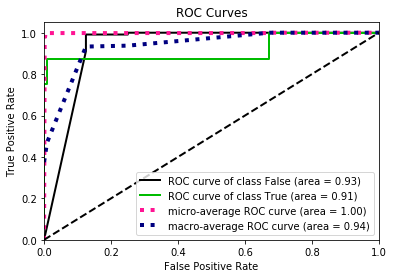

In [5]:
logistic = linear_model.LogisticRegression()

#Note:
# Because some businesses are not contained in the checkin dataset and some rows were dropped
# due to having None values in the precutoff time data after applying the Prediction Problem.
training_features = feature_matrix[feature_matrix.index.isin(first_label.business_id)]
training_labels = list(first_label['problem_label_excluding_data_post_cutoff_time'])
true_labels = first_label['problem_label_all_data']

logistic.fit(training_features, training_labels)
predicted_labels = logistic.predict(training_features)
predicted_probabilities = logistic.predict_proba(training_features)

accuracy = accuracy_score(true_labels, predicted_labels)
print("Classifier Accuracy: {0:.4f}".format(accuracy, prediction_problem))

accuracy_no_prediction = accuracy_score(training_labels, predicted_labels)
print("Baseline Accuracy Metric: {0:.4f}, based on using training_labels as the prediction".format(accuracy, prediction_problem))

skplt.metrics.plot_roc_curve(true_labels, predicted_probabilities)
plt.show()